In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from src import utils_model_training_ResNet50, utils_delete_png, utils_random_sample_folder, utils_list_file_dataset, utils_list_class_dataset

%config InlineBackend.figure_format = 'retina'


print("PyTorch version:", torch.__version__)

PyTorch version: 2.2.0+cu121


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


## Model

### Define where to store/load the best model & CSV file for model inference

In [4]:
best_model_path = "best_model_50_v1_crop_320_train_all_three_sources.pth"  # Define where to save the best model
path_to_save_csv = '../30_result/inference.csv'  # Define where to save the predictions

### Define transofrmation for the model input

In [5]:
# Define transforms for preprocessing the images
transform = transforms.Compose([
    transforms.CenterCrop(320), # Crop the center of the image
    transforms.Resize((224, 224)), # Resize the image to 224x224 so the model can process it
    transforms.ToTensor(), # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize the image based on the ImageNet statistics
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),  # Randomly rotate the image
    transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
])

## Create random samples to train and test

#### Delete the png files

In [6]:
path_of_png = '../00_source_data/png/'  # Define the path to the folder with the images
utils_delete_png.delete_png(path_of_png)  # Delete all the png files in the folder

#### Randomly split the samples into training and testing OR different folders

In [8]:
# Example of how to use the function
source_directory = '../00_source_data/Texas/Yes' 
destination_directory = '../00_source_data/train/Yes'
remaining_directory = '../00_source_data/test/Yes'

utils_random_sample_folder.copy_random_files(
    source_directory, destination_directory,
    remaining_directory,
    num_files=139,
    random_seed=42
    )

### create the list of names in training and test set

In [9]:
source_directory = '../00_source_data/random/'
df = utils_list_file_dataset.list_file_dataset(source_directory)
df.head(15)

In [10]:
# # load image_state.csv to df
# df_state = pd.read_csv('./data/image_state.csv')
# # merge the dataframes on the image column
# df = pd.merge(df, df_state, on='image', how='left')
# df.head(15)
# # save the dataframe to a csv file
# df.to_csv('./data/random/image_state_split.csv', index=False)

## Load the data

In [6]:
# Load the dataset
# train_dataset = ImageFolder("../00_source_data/California", transform=transform)
# test_dataset = ImageFolder("../00_source_data/Texas", transform=transform)
# train_dataset = ImageFolder("../00_source_data/Texas", transform=transform)
# test_dataset = ImageFolder("../00_source_data/California", transform=transform)
train_dataset = ImageFolder("../00_source_data/train/CA_TX_Combined", transform=transform)
test_dataset = ImageFolder("../00_source_data/test/", transform=transform)

In [7]:
# Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
model = utils_model_training_ResNet50.SceneClassifier(num_classes=2).to(device)

In [9]:
# Construct loss function object
criterion = nn.CrossEntropyLoss().to(device)

# Construct optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

## Visualize data

Here we investigate what a batch of our training data looks like.

Notice that our `images` tensor contains the normalized image data, and has shape NxCxHxW, and the `targets` tensor is essentially a list of corresponding target class labels with shape N (batch_size).

images: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]) torch.Size([32, 3, 224, 224])
targets: tensor([1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 0]) torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


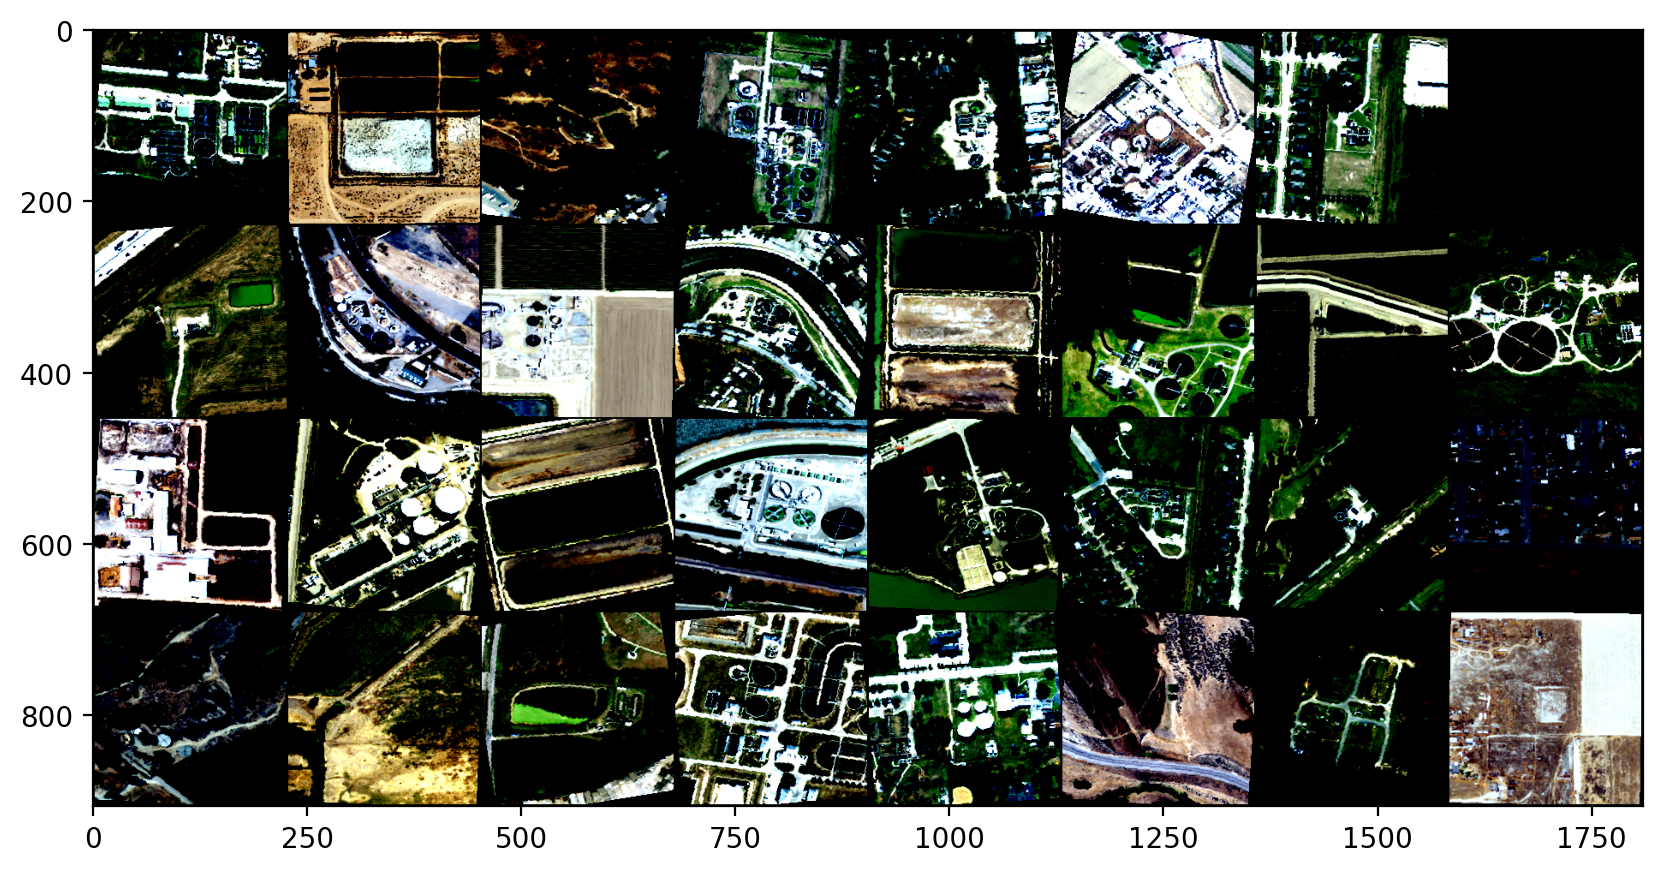

In [15]:
# Grab a batch of training data
images, targets = next(iter(train_loader))
# Print data tensors
print("images:", images[0], images.shape)
print("targets:", targets, targets.shape)

# Plot grid of images
grid_img = torchvision.utils.make_grid(images, 8)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [44]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 387
    Root location: data/train/CA_TX_Combined
    StandardTransform
Transform: Compose(
               CenterCrop(size=(320, 320))
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomVerticalFlip(p=0.5)
           )

In [34]:
# Get the list of classes in the training dataset
train_path = "../00_source_data/train/CA"
utils_list_class_dataset.list_class_dataset(train_path)

Class: No, Number of Files: 100
Class: Yes, Number of Files: 89


In [35]:
# Get the list of classes in the test directory
test_path = "./data/test/CA"
utils_list_class_dataset.list_class_dataset(test_path)


Class: No, Number of Files: 2314
Class: Yes, Number of Files: 89


## Train the model

In [ ]:
best_recall = 0.0

epochs = 17

for i in range(1, epochs + 1):
    # Put model in train mode
    model.train()
    print("\nEpoch [{}/{}]".format(i, epochs))

    total_ims = 0
    total_batches = 0
    total_loss = 0
    total_corrects = 0
    loss_list = []
    all_targets = []
    all_predicted = []
    all_probs = []

    # Wrap train_loader with tqdm for the progress bar
    train_loader_iter = tqdm(train_loader, desc=f'Epoch {i}/{epochs}', leave=False)

    # Train the training dataset for 1 epoch.
    for batch_idx, (images, targets) in enumerate(train_loader_iter):
        # Copy inputs to device
        images = images.to(device)
        targets = targets.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass images through model
        outputs = model(images)
        # Compute loss
        loss = criterion(outputs, targets)
        # Now backward loss
        loss.backward()
        # Apply gradient
        optimizer.step()
        # Calculate correct predictions
        _, predicted = torch.max(outputs, 1)
        # Append to totals
        total_ims += targets.shape[0]
        total_batches += 1
        total_loss += loss.item()
        total_corrects += predicted.eq(targets).sum().item()
        # Append targets, predicted, and probabilities for ROC curve calculation
        all_targets.extend(targets.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())
        all_probs.extend(nn.functional.softmax(outputs, dim=1).detach().cpu().numpy())

    avg_loss = total_loss / total_batches
    loss_list.append(avg_loss)
    acc = (total_corrects / total_ims) * 100.0
    print("Training loss: %.4f, Training accuracy: %.4f" % (avg_loss, acc))

    # Calculate precision, recall, and F1 score
    precision = precision_score(all_targets, all_predicted, average='macro')
    recall = recall_score(all_targets, all_predicted, average='macro')
    f1 = f1_score(all_targets, all_predicted, average='macro')

    print("Precision: %.4f, Recall: %.4f, F1 Score: %.4f" % (precision, recall, f1))

    # Check if current recall is better than the previous best recall
    if recall > best_recall:
        # Save the model
        torch.save(model.state_dict(), best_model_path)
        print("Best model saved at:", best_model_path)
        # Update the best recall value
        best_recall = recall

    # Extract probabilities of the positive class
    positive_probs = [prob[1] for prob in all_probs]

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(all_targets, positive_probs, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # plot the loss
    plt.plot(loss_list)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


## Test the model

Now that we have a trained model, we can test its performance on the test set.

To do this we use a similar loop to our training procedure, but we do not need to compute gradients or update the model.

  0%|          | 0/76 [00:00<?, ?it/s]

100%|██████████| 76/76 [04:17<00:00,  3.39s/it]


Test loss: 1.3692, Test accuracy: 47.7320
Precision: 0.5283, Recall: 0.6962, F1 Score: 0.3728


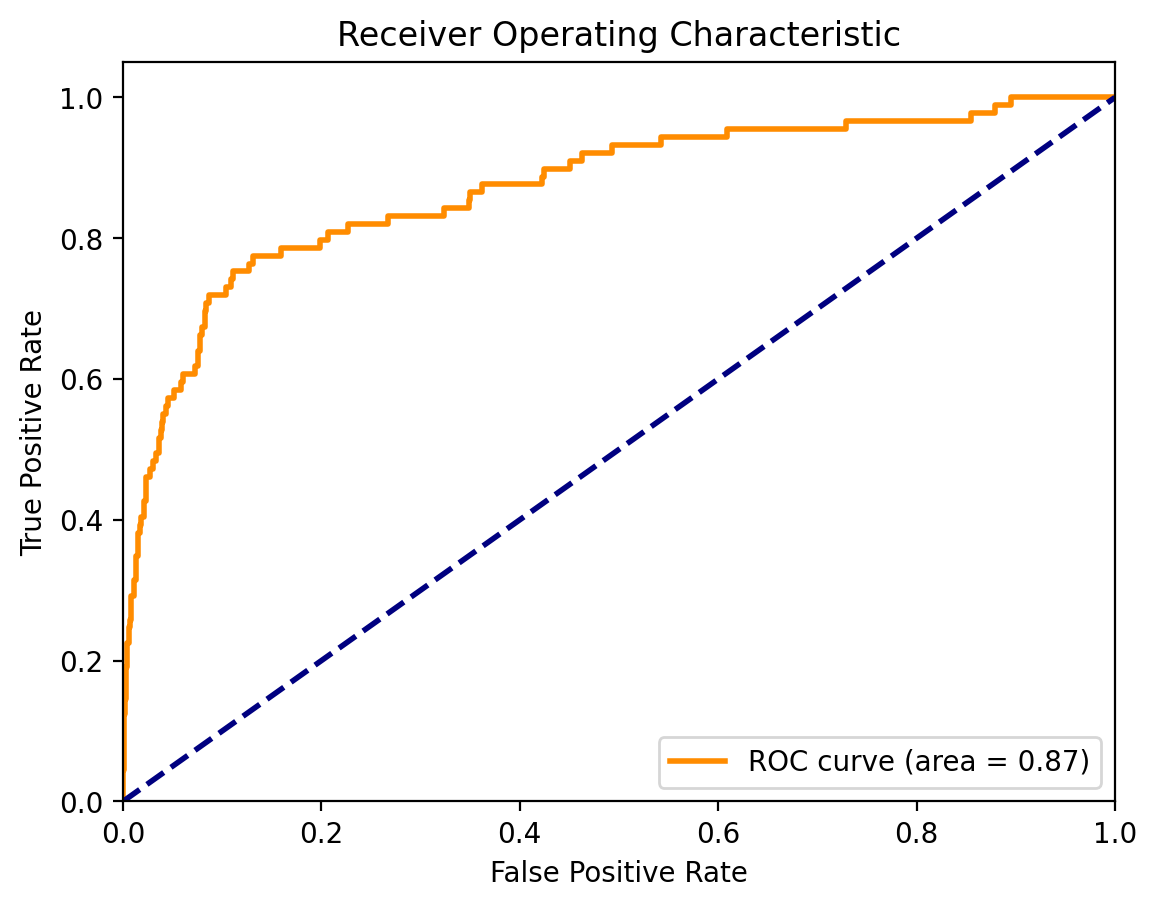

In [17]:
def test_model(model, test_loader, criterion, device):
    total_ims = 0
    total_batches = 0
    total_loss = 0
    total_corrects = 0
    all_targets = []
    all_predicted = []
    all_probs = []

    # Put model in eval mode
    model.eval()

    # Do NOT compute gradients
    with torch.no_grad(), tqdm(total=len(test_loader)) as progress_bar:
        # Run inference on each image in the test set (use batches to make process faster)
        for batch_idx, (images, targets) in enumerate(test_loader):
            # Copy inputs to device
            images = images.to(device)
            targets = targets.to(device)
            # Forward pass images through model
            outputs = model(images)
            # Compute loss
            loss = criterion(outputs, targets)
            # Calculate correct predictions
            _, predicted = torch.max(outputs, 1)
            # Append to totals
            total_ims += targets.shape[0]
            total_batches += 1
            total_loss += loss.item()
            total_corrects += predicted.eq(targets).sum().item()
            # Append targets, predicted, and probabilities for precision, recall, and ROC curve calculation
            all_targets.extend(targets.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())
            all_probs.extend(nn.functional.softmax(outputs, dim=1).cpu().numpy())
            progress_bar.update(1)

    avg_loss = total_loss / total_batches
    acc = (total_corrects / total_ims) * 100.0
    print("Test loss: %.4f, Test accuracy: %.4f" % (avg_loss, acc))

    # Calculate precision, recall, and F1 score
    precision = precision_score(all_targets, all_predicted, average='macro')
    recall = recall_score(all_targets, all_predicted, average='macro')
    f1 = f1_score(all_targets, all_predicted, average='macro')

    print("Precision: %.4f, Recall: %.4f, F1 Score: %.4f" % (precision, recall, f1))

    # Extract probabilities of the positive class
    positive_probs = [prob[1] for prob in all_probs]

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(all_targets, positive_probs, pos_label=1)
    roc_auc_val = auc(fpr, tpr)

    # save fpr, tpr, and thresholds to a csv file
    df = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})
    df.to_csv(path_to_save_csv, index=False)
    

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_val)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Load the best weights saved during training
model.load_state_dict(torch.load(best_model_path))

# Call test_model
test_model(model, test_loader, criterion, device)


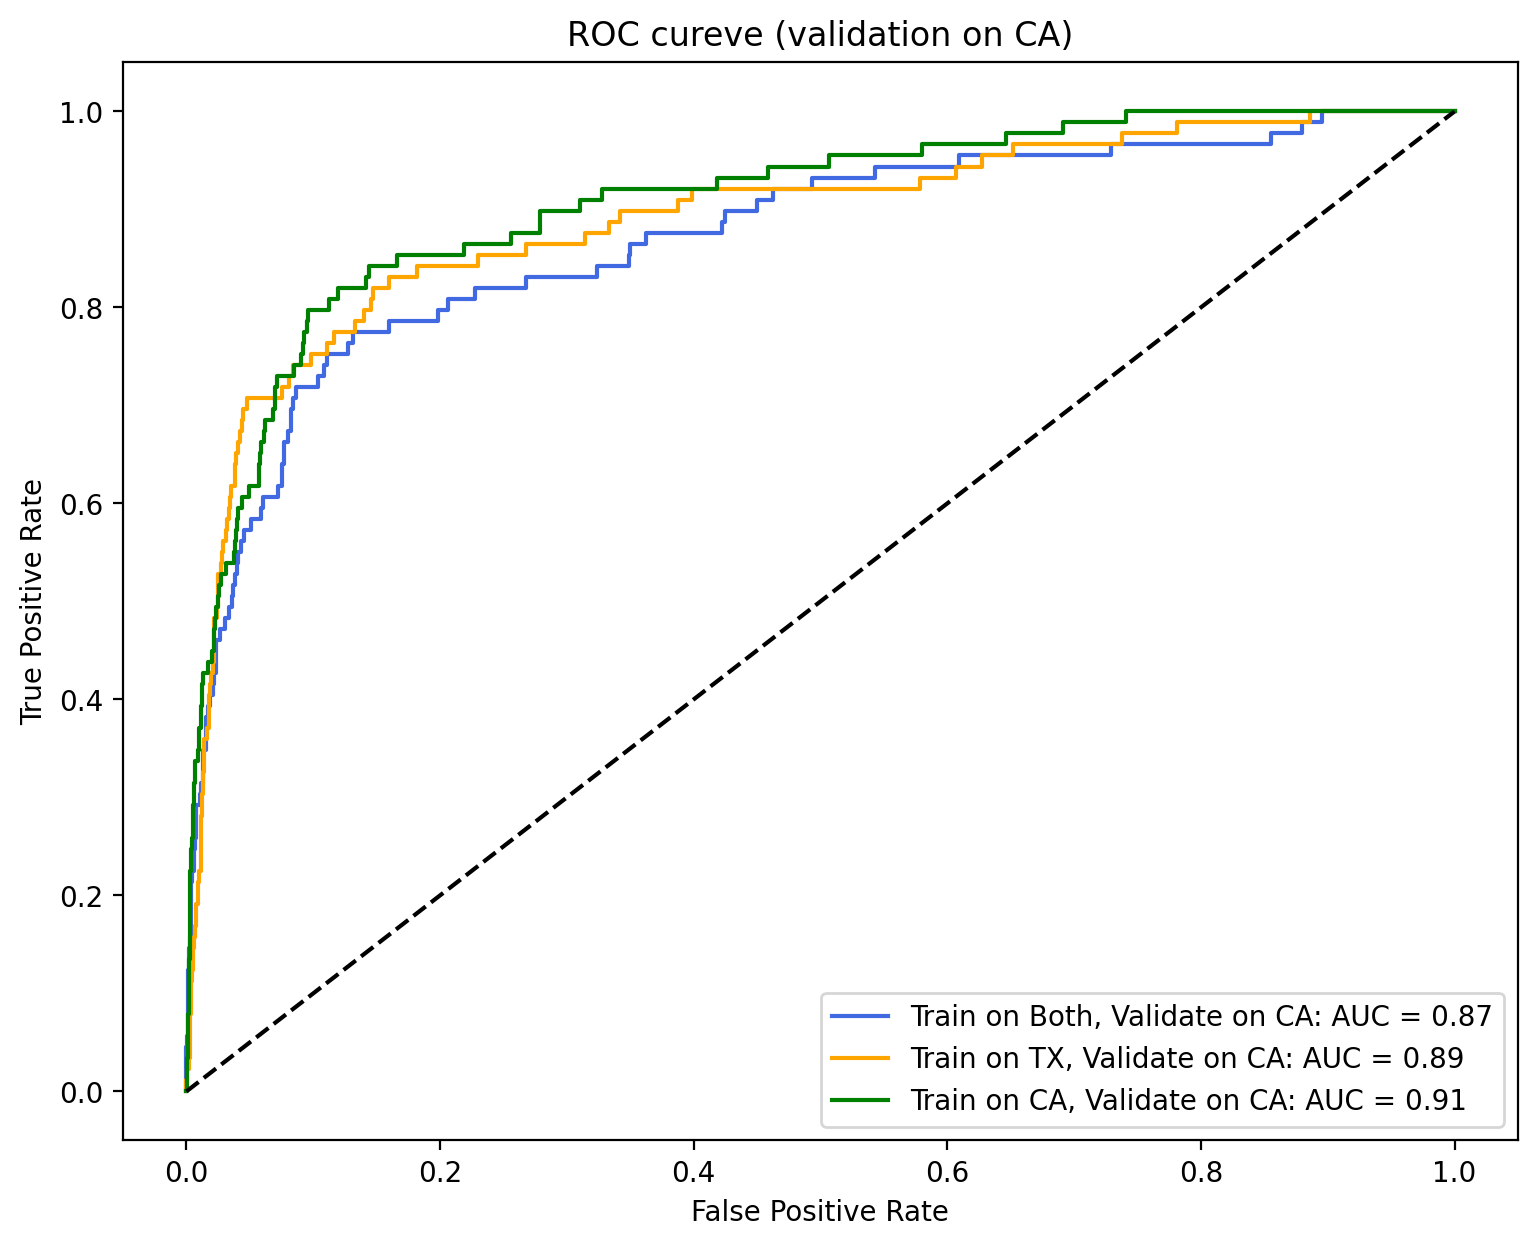

In [31]:
# import other csv as dataframe
df_tx_ca = pd.read_csv('./results/roc_curve_resnet_50_v1_crop_320_train_TX_val_CA.csv')
df_ca_ca = pd.read_csv('./results/roc_curve_resnet_50_v1_crop_320_train_CA_val_CA.csv')
df_both_ca = pd.read_csv('./results/roc_curve_resnet_50_v1_crop_320_train_both_val_CA.csv') 
auc_tx_ca = auc(df_tx_ca['fpr'], df_tx_ca['tpr'])
auc_ca_ca = auc(df_ca_ca['fpr'], df_ca_ca['tpr'])
auc_both_ca = auc(df_both_ca['fpr'], df_both_ca['tpr'])

# plot the ROC curve
plt.figure(figsize=(9, 7))
plt.plot(df_both_ca['fpr'], df_both_ca['tpr'], color='royalblue', label= f'Train on Both, Validate on CA: AUC = {auc_both_ca:.2f}')
plt.plot(df_tx_ca['fpr'], df_tx_ca['tpr'], color='orange', label= f'Train on TX, Validate on CA: AUC = {auc_tx_ca:.2f}')
plt.plot(df_ca_ca['fpr'], df_ca_ca['tpr'], color='green', label= f'Train on CA, Validate on CA: AUC = {auc_ca_ca:.2f}')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC cureve (validation on CA)')
plt.legend(loc="lower right")
plt.show()


## Saving and loading models

The last basic procedure that we will cover is how to save and load PyTorch models. 

In this example, we wish to save the model to disk to be used for inference later. To do this, we simply use `torch.save` to save the model's `state_dict`, which is a Python dictionary that contains all of the parameters of the module.



For a detailed outline on the many ways to save and load models (e.g., save/load across devices, save/load for finetuning, etc.), see the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/saving_loading_models.html). 

In [22]:
# Save model
# torch.save(model.state_dict(), best_model_path)

## Predicting with the model with weights

In [10]:
# Load model
model = SceneClassifier(num_classes=2).to(device)
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [11]:
# for f in glob.glob('data/North Carolina/*/*.png'):
#     os.remove(f)

In [12]:
path_to_pred = './data/prediction'
path_to_save_csv = './results/predictions_best_mississippi.csv'  # Define where to save the predictions

In [13]:
# # load NC as prediction
# pred = ImageFolder("data/North Carolina", transform=transform)
# pred_loader = DataLoader(pred, batch_size=len(pred), shuffle=False)
# load random test as prediction
# Set the model to evaluation mode
model.eval()

pred = ImageFolder(path_to_pred, transform=transform)
pred_loader = DataLoader(pred, batch_size=64, shuffle=False)

In [14]:
pred

Dataset ImageFolder
    Number of datapoints: 371
    Root location: ./data/prediction
    StandardTransform
Transform: Compose(
               CenterCrop(size=(320, 320))
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomVerticalFlip(p=0.5)
           )

In [24]:
# # Set the model to evaluation mode
# model.eval()

# # Initialize tqdm to track progress
# with tqdm(total=len(pred_loader.dataset), desc='Predicting labels') as progress_bar:
#     # Iterate over the DataLoader in batches
#     for batch_images, _ in pred_loader:
#         # Move batch_images to device
#         batch_images = batch_images.to(device)

#         # Make predictions
#         with torch.no_grad():
#             outputs = model(batch_images).to(device)
#             _, predicted = torch.max(outputs, 1)

#             # Print the number of predictions being made
#             print("Number of predictions:", len(predicted))

#         # Update progress bar
#         progress_bar.update(len(predicted))

In [25]:
# Set the threshold for classification
threshold = 0.2236

# Set the model to evaluation mode
model.eval()

# Initialize lists to store filenames and labels
filenames = []
class_labels = []

# Initialize tqdm to track progress
with tqdm(total=len(pred_loader.dataset), desc='Predicting labels') as progress_bar:
    # Iterate over the DataLoader in batches
    for batch_images, _ in pred_loader:
        # Move batch_images to device
        batch_images = batch_images.to(device)

        # Make predictions
        with torch.no_grad():
            outputs = model(batch_images).to(device)
            probabilities = torch.softmax(outputs, dim=1)
            predicted = (probabilities[:, 1] > threshold).int()  # Apply threshold

        # Convert class indices to class labels
        class_labels.extend([test_dataset.classes[idx] for idx in predicted])

        # Get the filenames for this batch
        batch_filenames = pred_loader.dataset.samples[len(filenames):len(filenames) + len(batch_images)]
        batch_filenames = [os.path.basename(f[0]) for f in batch_filenames]
        filenames.extend(batch_filenames)

        # Update progress bar
        progress_bar.update(len(batch_images))

# Create a dataframe
df = pd.DataFrame({"filename": filenames, "label": class_labels})

# Save to a CSV file
df.to_csv(path_to_save_csv, index=False)


Predicting labels: 100%|██████████| 372/372 [00:38<00:00,  9.57it/s]


In [26]:
df.label.value_counts()

No     268
Yes    104
Name: label, dtype: int64

## If have ground truth and we want to compare with the model's prediction

### Set up ground truth csv

In [29]:
# Define the path to the folder containing class folders
random_folder = "./data/random/test"

# Initialize lists to store filenames and ground truth labels
filenames = []
ground_truth_labels = []

# Iterate over class folders
for class_folder in os.listdir(random_folder):
    class_folder_path = os.path.join(random_folder, class_folder)
    if os.path.isdir(class_folder_path):
        # Iterate over files in the class folder
        for filename in os.listdir(class_folder_path):
            # Append filename and ground truth label
            filenames.append(filename)
            ground_truth_labels.append(class_folder)

# Create a DataFrame
df_ground_truth = pd.DataFrame({"filename": filenames, "ground_truth_label": ground_truth_labels})

In [30]:
df_ground_truth.head()

,filename,ground_truth_label
0,Plant_75118669.tif,No
1,Plant_76127551.tif,No
2,Plant_372655141.tif,No
3,Plant_75119332.tif,No
4,Plant_82589020.tif,No


In [31]:
# load prediction and compare against ground truth
df_pred = pd.read_csv(path_to_save_csv)

# Merge the DataFrames on the filename column
df_merged = df_ground_truth.merge(df_pred, on="filename")

# Display the first few rows of the merged DataFrame
df_merged.head()

,filename,ground_truth_label,label
0,Plant_75118669.tif,No,No
1,Plant_76127551.tif,No,No
2,Plant_372655141.tif,No,No
3,Plant_75119332.tif,No,No
4,Plant_82589020.tif,No,No


In [32]:
# Add a column to indicate if the prediction is correct
df_merged["correct"] = df_merged["ground_truth_label"] == df_merged["label"]

# Display the first few rows of the merged DataFrame
df_merged.head()

,filename,ground_truth_label,label,correct
0,Plant_75118669.tif,No,No,True
1,Plant_76127551.tif,No,No,True
2,Plant_372655141.tif,No,No,True
3,Plant_75119332.tif,No,No,True
4,Plant_82589020.tif,No,No,True


In [33]:
# save the merged dataframe
df_merged.to_csv(path_to_save_csv, index=False)

In [34]:
# count the number of correct predictions with groud truth of yes
correct_yes = df_merged[(df_merged["ground_truth_label"] == "Yes") & (df_merged["correct"] == True)].shape[0]
# count the number of correct predictions with groud truth of no
correct_no = df_merged[(df_merged["ground_truth_label"] == "No") & (df_merged["correct"] == True)].shape[0]
# count the number of incorrect predictions with groud truth of yes
incorrect_yes = df_merged[(df_merged["ground_truth_label"] == "Yes") & (df_merged["correct"] == False)].shape[0]
# count the number of incorrect predictions with groud truth of no
incorrect_no = df_merged[(df_merged["ground_truth_label"] == "No") & (df_merged["correct"] == False)].shape[0]

# Print the counts
print("Correct Yes:", correct_yes)
print("Correct No:", correct_no)
print("Incorrect Yes:", incorrect_yes)
print("Incorrect No:", incorrect_no)

Correct Yes: 6
Correct No: 2372
Incorrect Yes: 222
Incorrect No: 1
